In [2]:
import os
import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
import jax.numpy as jnp
from jax import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import optax
import jax
import jax.numpy as jnp
from jax import random, jit, grad
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming equivalent JAX implementations
from src.jax_subspace_curve import BezierCoeff, OrthoSpan, SubspaceModel


%load_ext autoreload
%autoreload 2

# %env XLA_FLAGS="--xla_force_host_platform_device_count=10"
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%env XLA_FLAGS

jax.devices("gpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[cuda(id=0)]

### Load data

Data shapes: (70, 1) (70,) (33, 1) (33,)


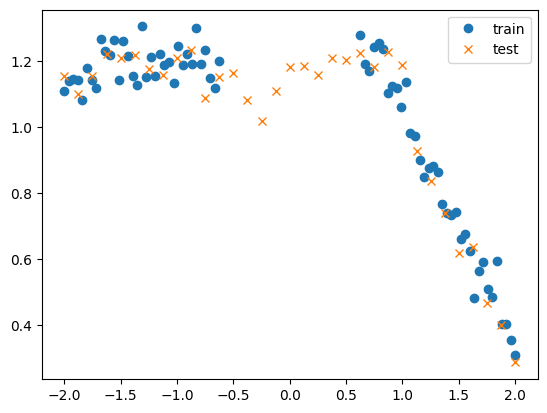

In [3]:
# load data
data = np.load('regression_data.npz')
x = jnp.array(data['x'])
y = jnp.array(data['y'])
x_test = jnp.array(data['xt'])
y_test = jnp.array(data['yt'])
plt.plot(x, y, 'o', label='train')
plt.plot(x_test, y_test, 'x', label='test')
plt.legend()
print("Data shapes:", x.shape, y.shape, x_test.shape, y_test.shape)

### Define model structure

In [4]:
class MLPModel(nn.Module):
    depth: int = 3
    width: int = 10

    @nn.compact
    def __call__(self, x,):
        x = jnp.concat([x, x**2], axis=-1)
        for _ in range(self.depth):
            x = nn.Dense(self.width)(x)
            x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x


model = MLPModel(depth=3, width=10)

: 

### Train using adam and compute expectation with 10 samples

100%|██████████| 10000/10000 [00:06<00:00, 1526.05it/s]


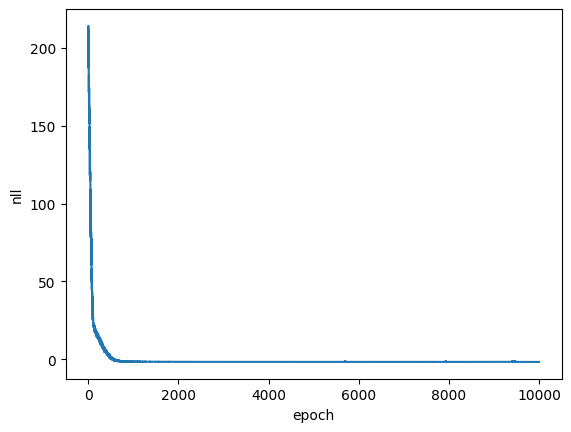

In [4]:
k = 10
key = random.PRNGKey(2)
key, init_key = random.split(key)
s_model = SubspaceModel(model, k, n_samples=10)
params = s_model.init_params(init_key, x)

# Train
lr = 0.001
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

losses = []
for i in tqdm(range(10000)):
    key, subkey = random.split(key)
    loss, params, opt_state = s_model.train_step(subkey, params, x, y, opt_state, optimizer)
    losses.append(loss)

plt.plot(losses)
plt.ylabel("nll")
plt.xlabel("epoch")
plt.show()

Text(0.5, 0, 'epoch')

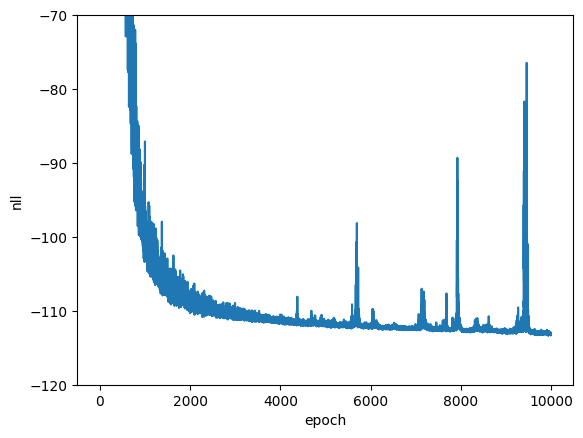

In [5]:
# use the same resolution as in pytorch
plt.plot(jnp.array(losses)*70)
plt.ylim(-120, -70)
plt.ylabel("nll")
plt.xlabel("epoch")

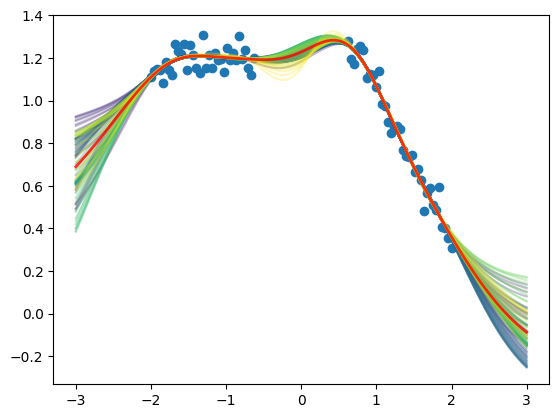

In [6]:
t_space = jnp.linspace(0, 1, 100)
x_lin = jnp.linspace(-3, 3, 100)[:, None]
out = s_model(params, t_space, x_lin).squeeze(axis=-1)
plt.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    plt.plot(x_lin, o, color=c, alpha=0.3)
plt.plot(x_lin, out.mean(axis=0), label='mean', c='red', linewidth=2, alpha=0.8)

#### Loss Barier

Text(0, 0.5, 'log like')

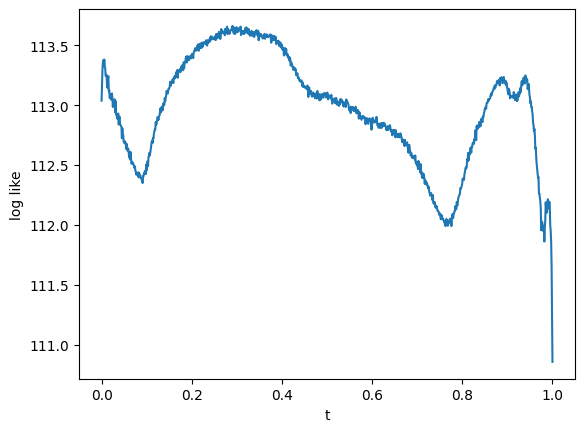

In [7]:
t_space = jnp.linspace(0.0, 1.0, 1000)
nll = s_model.nll(params, t_space, x, y).sum(axis=-1)

plt.plot(t_space, -nll)
plt.xlabel("t")
plt.ylabel("log like")

### run MCMC

In [10]:
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import BezierCurve, pytree_to_matrix, vec_to_pytree

#### construct subspace

In [11]:
# get design matrix from curve parameters stroed as pytree
cp_w = pytree_to_matrix(params, k)
# define the transformation function between weight space and phi space
t_phi_to_weight = OrthoSpan(cp_w)
# control points in the varphi space
cp_phi = t_phi_to_weight.inv(cp_w)
print(f"Control points in phi space: {cp_phi.shape}")

curve = partial(BezierCurve(
    num_bends=k+1), cp=cp_phi)
d_bezier = partial(BezierCurve(k+1).derivative_bezier, cp=cp_phi)

Control points in phi space: (11, 10)


space_at_t0 shape (10, 10)
Stores 13 orthogonal frames  
with ortho frame shape (13, 10, 10)


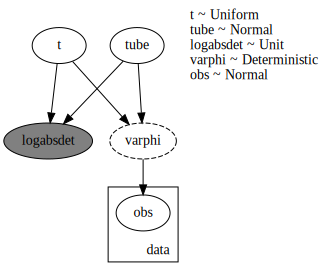

In [25]:
# init orthogonal segments for Bezier curve
t_cut, ortho_at_tcut = init_curve_frame_cp(
    d_bezier, cp_phi, epsilon=5.)

# define fuction to generate orthogonal space at location t
def generate_ortho_space(t, d_bezier, t_cut, ortho_at_tcut, k):
    ortho_space = jax.vmap(ortho_at_one_t, in_axes=(0, None, None, None, None))(
        t, d_bezier, t_cut, ortho_at_tcut, k)
    return ortho_space
generate_space = partial(generate_ortho_space, d_bezier=d_bezier,
                         t_cut=t_cut, ortho_at_tcut=ortho_at_tcut, k=k)

@jax.jit
def t_lambda_to_phi(l):
    t = l[..., 0:1]
    tube = l[..., 1:]
    space_point = curve(t)
    ortho_space = generate_space(t)
    # first vector is the tangent vector alonge bezier curve
    ortho_space = ortho_space[:, 1:, :]
    if tube.ndim == 1:
        space_point += jnp.einsum("tok,o->tk", ortho_space, tube)  # t=1
    else:
        space_point += jnp.einsum("tok,to->tk", ortho_space, tube)
    return space_point

def model_tube(x,y=None, temperature=1.):
    t = numpyro.sample("t", dist.Uniform(-0.3, 1.3).expand((1,)).to_event(1))
    tube = numpyro.sample("tube", dist.Normal(0., 1.).expand((k-1,)).to_event(1))
    lambda_ = jnp.concat([t, tube/10.], axis=-1)
    space_point = t_lambda_to_phi(lambda_)

    # jacobian = jax.jacrev(transform)(jax.lax.stop_gradient(lambda_)).squeeze()
    jacobian = jax.jacrev(t_lambda_to_phi)(lambda_).squeeze()
    sign, logabsdet = jnp.linalg.slogdet(jacobian)
    numpyro.factor("logabsdet", logabsdet)

    varphi = numpyro.deterministic('varphi', space_point.squeeze(0))
    weight_vec = t_phi_to_weight(varphi)
    def apply_model(weight_vec, x):
        weight_pytree = vec_to_pytree(weight_vec, params)
        out = model.apply({'params': weight_pytree}, x)
        return out
    if weight_vec.ndim == 1:
        out = apply_model(weight_vec, x)
    else:
        out = jax.vmap(apply_model, in_axes=(0,None))(weight_vec, x)
    with numpyro.plate("data", x.shape[0], dim=-1):
        with handlers.scale(scale=1/temperature):
            numpyro.sample("obs", dist.Normal(out.squeeze(-1), .05), obs=y)


# Example usage:
numpyro.render_model(model_tube, model_args=(
    x,), render_distributions=True)

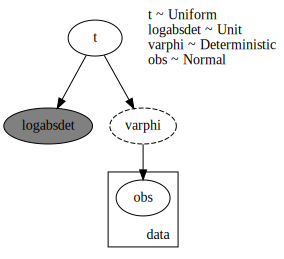

In [14]:
def model_line(x, y=None, temperature=1.):
    t = numpyro.sample("t", dist.Uniform(-0.3, 1.3).expand((1,)).to_event(1))
    tube = jnp.zeros(k-1)
    lambda_ = jnp.concat([t, tube], axis=-1)
    space_point = t_lambda_to_phi(lambda_)

    # jacobian = jax.jacrev(transform)(jax.lax.stop_gradient(lambda_)).squeeze()
    jacobian = jax.jacrev(t_lambda_to_phi)(lambda_).squeeze()
    sign, logabsdet = jnp.linalg.slogdet(jacobian)
    numpyro.factor("logabsdet", logabsdet)

    varphi = numpyro.deterministic('varphi', space_point.squeeze(0))
    weight_vec = t_phi_to_weight(varphi)

    def apply_model(weight_vec, x):
        weight_pytree = vec_to_pytree(weight_vec, params)
        out = model.apply({'params': weight_pytree}, x)
        return out
    if weight_vec.ndim == 1:
        out = apply_model(weight_vec, x)
    else:
        out = jax.vmap(apply_model, in_axes=(0, None))(weight_vec, x)
    with numpyro.plate("data", x.shape[0], dim=-1):
        with handlers.scale(scale=1/temperature):
            numpyro.sample("obs", dist.Normal(out.squeeze(-1), .05), obs=y)


# Example usage:
numpyro.render_model(model_line, model_args=(
    x,), render_distributions=True)

In [13]:
with handlers.seed(rng_seed=0):
    traced = handlers.trace(model_tube).get_trace(x)
print(numpyro.util.format_shapes(traced))

 Trace Shapes:       
  Param Sites:       
 Sample Sites:       
        t dist    | 1
         value    | 1
     tube dist    | 9
         value    | 9
logabsdet dist    | 0
         value    | 0
    data plate 70 |  
      obs dist 70 |  
         value 70 |  


(250000,)


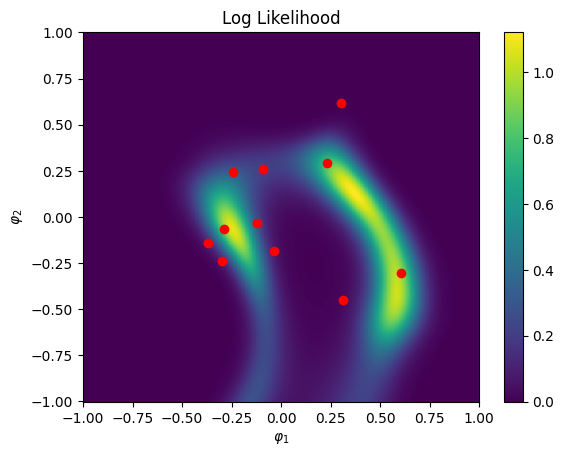

In [26]:
# Define the grid
xx = jnp.linspace(-1, 1., 500)
yy = jnp.linspace(-1, 1, 500)
X, Y = jnp.meshgrid(xx, yy)
phi_grid = jnp.stack([X, Y] + [jnp.zeros_like(X)] * (k - 2), axis=-1)
X, Y = X, Y

cml = handlers.substitute(model_tube, data={'varphi': phi_grid.reshape(-1, k)})
ex_trace = handlers.trace(handlers.seed(cml, random.PRNGKey(0))
                 ).get_trace(x,y, 10.)
site = ex_trace['obs']
log_like = (site['fn'].log_prob(site['value']) * site['scale']).mean(-1)
print(log_like.shape)

# Set values less than -50 to -50 for better visualization
# log_like = log_like.at[log_like <= -50].set(-50)
like = jnp.exp(log_like).reshape(X.shape)
plt.figure()
plt.pcolormesh(X, Y, like, cmap='viridis')
plt.colorbar()
plt.xlabel(r'$\varphi_1$')
plt.ylabel(r'$\varphi_2$')
plt.title('Log Likelihood')
plt.scatter(cp_phi[:, 0], cp_phi[:,
            1], c='r', label='Control Points')
plt.show()

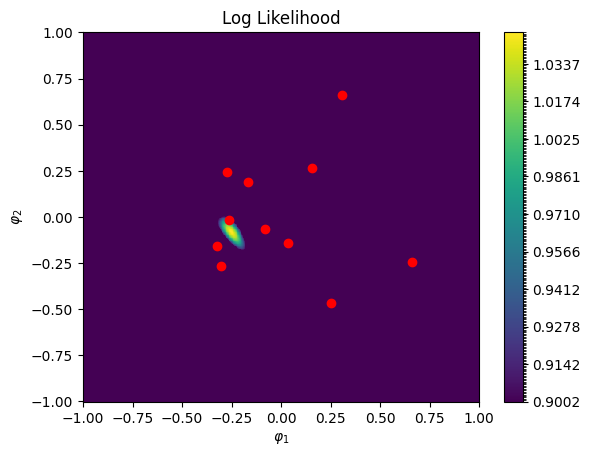

In [115]:
from matplotlib import colors as mcolors

landscape = like.reshape(X.shape)
cmap = plt.cm.viridis
vmin, vmax = .9, landscape.max()
# compute boundaries according data quantile (step_size=1/255)
levels = [np.quantile(landscape[(landscape <= vmax) & (
    landscape >= vmin)], (1 / cmap.N * i)) for i in range(cmap.N)]
levels.append(vmax)
norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.figure()
plt.pcolormesh(X, Y, like, cmap=cmap, norm=norm)
plt.colorbar()
plt.xlabel(r'$\varphi_1$')
plt.ylabel(r'$\varphi_2$')
plt.title('Log Likelihood')
plt.scatter(cp_phi[:, 0], cp_phi[:,
            1], c='r', label='Control Points')
plt.show()

In [27]:
from numpyro.infer.util import initialize_model
import blackjax

num_warmup = 500
num_chains = 10
num_draws = 1000
temperature = 1.

# generate initial values for each chain
rng_key = random.PRNGKey(2)
rng_key, init_key = jax.random.split(rng_key)
initial_position = {'t':jax.random.uniform(init_key, (num_chains, 1), minval=0., maxval=1.), 
                    'tube':jnp.zeros((num_chains, k-1))}
print("initial_position shape:", initial_position['t'].shape)

# run warmup adaption
rng_key, warmup_key = jax.random.split(rng_key)
warmup_key = jax.random.split(warmup_key, num_chains)

init_params, potential_fn, post_proc_fun, _ = initialize_model(
    init_key,
    # model_tube,
    model_tube,
    model_args=(x, y, temperature),
    # could also set to True => potential_fn_gen(**model_args) instead of potential_fn
    dynamic_args=False,
)

rng_key, key = jax.random.split(rng_key)


def logdensity_fn(params):
    return -potential_fn(params)


def init_fn(num_warmup, warmup_key, initial_position):
    adapt = blackjax.window_adaptation(
        blackjax.nuts, logdensity_fn, target_acceptance_rate=0.8,  is_mass_matrix_diagonal=True, initial_step_size=0.2
    )
    (last_state, parameters), _ = adapt.run(
        warmup_key, initial_position, num_warmup)
    return last_state, parameters


last_state, parameters = jax.pmap(init_fn, in_axes=(None, 0, 0), static_broadcasted_argnums=(0,), devices=jax.devices('cpu'))(
    num_warmup, warmup_key, initial_position)
print("MCMC parameters:", parameters)


def inference_loop(rng_key, parameters, initial_state, num_samples):
    kernel = blackjax.nuts(logdensity_fn, **parameters).step

    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

initial_position shape: (10, 1)
MCMC parameters: {'inverse_mass_matrix': Array([[0.26270032, 0.30652002, 0.11553617, 0.36321503, 0.3943523 ,
        0.3248415 , 0.50592214, 0.21894938, 0.37643668, 0.37232578],
       [0.29959086, 0.30773184, 0.18366697, 0.30200428, 0.5709658 ,
        0.34370518, 0.5643006 , 0.22193605, 0.2162825 , 0.47834533],
       [0.30438972, 0.22106773, 0.15342271, 0.32783994, 0.46774337,
        0.33926404, 0.39412397, 0.16519476, 0.19939815, 0.4256814 ],
       [0.14363752, 0.24731947, 0.14351259, 0.32316014, 0.488953  ,
        0.4222524 , 0.4452391 , 0.17636813, 0.20479256, 0.47294328],
       [0.13112603, 0.23533665, 0.13775156, 0.3932027 , 0.3723352 ,
        0.3820309 , 0.47480828, 0.15742505, 0.19590463, 0.5470942 ],
       [0.13590437, 0.32140896, 0.23964918, 0.34872863, 0.39659086,
        0.4078247 , 0.5210531 , 0.19591641, 0.32324228, 0.6705739 ],
       [0.50808984, 0.32304356, 0.18404225, 0.28781337, 0.35387114,
        0.35213116, 0.48633415, 0.181

In [24]:
parameters['inverse_mass_matrix']

Array([[1.31994067e-03, 1.93936840e-01, 7.00661018e-02, 2.56103963e-01,
        5.12060262e-02, 1.43345848e-01, 2.03403950e-01, 6.27544522e-02,
        2.88801733e-02, 5.51204421e-02],
       [6.73099637e-01, 2.16385648e-01, 2.45682269e-01, 2.07592845e-01,
        1.76812232e-01, 1.00340031e-01, 2.39292234e-01, 1.24067143e-01,
        1.50244385e-01, 2.11810961e-01],
       [1.31222665e+00, 9.96613428e-02, 2.40046754e-01, 2.33266458e-01,
        9.70488042e-02, 6.45541996e-02, 1.54119119e-01, 1.89920723e-01,
        1.52832672e-01, 1.18255772e-01],
       [1.36039329e+00, 2.18389422e-01, 1.88485786e-01, 3.51360738e-01,
        1.31005928e-01, 9.46294889e-02, 1.28964871e-01, 3.94794121e-02,
        7.92449117e-02, 1.17400318e-01],
       [6.24601066e-01, 1.21610098e-01, 1.15396440e-01, 1.77323475e-01,
        2.07056090e-01, 1.02814622e-01, 1.04100190e-01, 4.80742753e-02,
        1.02052025e-01, 9.70501453e-02],
       [4.00408089e-01, 1.38864756e-01, 1.36879846e-01, 1.01100817e-01,
   

In [24]:
parameters2 = parameters.copy()
parameters2['inverse_mass_matrix'] = parameters2['inverse_mass_matrix'].at[:,
                                                                           0].multiply(10.)
# parameters2['step_size'] = parameters2['step_size'].at[:].multiply(1.5)
parameters2['inverse_mass_matrix']

Array([[2.6745548 , 0.07910615, 0.11097577, 0.16405773, 0.20792209,
        0.21279074, 0.18594387, 0.144938  , 0.11179026, 0.19007413],
       [1.3257693 , 0.14448117, 0.18967001, 0.16403218, 0.15407364,
        0.13377103, 0.24326156, 0.16427164, 0.17684077, 0.21833967],
       [0.22747354, 0.21958385, 0.21356678, 0.17160407, 0.25668058,
        0.34266913, 0.6663111 , 0.07933468, 0.08900237, 0.07023977],
       [0.22291562, 0.23046064, 0.08694775, 0.17163204, 0.14161555,
        0.09707653, 0.14759202, 0.23496078, 0.3313382 , 0.17759278],
       [1.5583099 , 0.23400524, 0.1289639 , 0.35182112, 0.15665975,
        0.12954548, 0.13910471, 0.09410685, 0.0842197 , 0.17226902],
       [2.327254  , 0.18495978, 0.10798794, 0.13773225, 0.16383822,
        0.17723814, 0.0948689 , 0.22105743, 0.10720943, 0.10211683],
       [1.4398313 , 0.11523838, 0.24743365, 0.07133912, 0.15027447,
        0.17792812, 0.18296401, 0.09506174, 0.10681637, 0.14695302],
       [0.48734033, 0.25975406, 0.2916295

In [17]:
inference_loop_multiple_chains = jax.pmap(inference_loop, in_axes=(
    0, 0, 0, None), static_broadcasted_argnums=(3,), devices=jax.devices('cpu'))
rng_key, sample_key = jax.random.split(rng_key)
sample_keys = jax.random.split(sample_key, num_chains)

pmap_states, pmap_infos = inference_loop_multiple_chains(
    sample_keys, parameters, last_state, num_draws)
_ = pmap_states.position["t"].block_until_ready()

In [18]:
print("sample shapes:", pmap_states.position["t"].shape)
idata = az.from_dict(posterior=jax.vmap(
    jax.vmap(post_proc_fun))(pmap_states.position))
az.summary(idata)

sample shapes: (10, 1000, 1)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
t[0]       0.553  0.343  -0.018    1.003      0.097    0.070      14.0   
tube[0]   -0.173  0.451  -1.138    0.511      0.092    0.068      28.0   
tube[1]   -0.016  0.404  -0.736    0.846      0.080    0.057      26.0   
tube[2]   -0.118  0.457  -1.001    0.714      0.087    0.062      28.0   
tube[3]    0.141  0.450  -0.623    1.141      0.075    0.053      36.0   
tube[4]    0.180  0.351  -0.443    0.916      0.070    0.050      25.0   
tube[5]   -0.020  0.365  -0.712    0.608      0.068    0.049      29.0   
tube[6]   -0.045  0.320  -0.618    0.716      0.072    0.051      25.0   
tube[7]   -0.243  0.359  -0.911    0.382      0.053    0.038      46.0   
tube[8]    0.093  0.383  -0.774    0.756      0.075    0.054      26.0   
varphi[0]  0.081  0.368  -0.496    0.844      0.081    0.058      22.0   
varphi[1]  0.007  0.332  -0.606    0.662      0.070    0.050      22.0   
varphi[2] -0.029  0.350  -0.682    0.609      0.063    0.045      31.0   
varphi[3]  0.052  0.341  -0.590    0.673      0.063    0.045      29.0   
varphi[4]  0.151  0.339  -0.431    0.839      0.058    0.041      36.0   
varphi[5] -0.047  0.375  -0.799    0.628      0.066    0.047      32.0   
varphi[6]  0.246  0.328  -0.390    0.887      0.047    0.040      48.0   
varphi[7]  0.303  0.533  -0.729    1.281      0.101    0.072      30.0   
varphi[8]  0.182  0.469  -0.590    1.125      0.095    0.068      25.0   
varphi[9]  0.000  0.439  -0.738    1.002      0.074    0.062      40.0   

           ess_tail  r_hat  
t[0]           59.0   1.85  
tube[0]        44.0   1.29  
tube[1]        69.0   1.30  
tube[2]        51.0   1.27  
tube[3]        92.0   1.21  
tube[4]        61.0   1.31  
tube[5]        63.0   1.25  
tube[6]        30.0   1.32  
tube[7]        61.0   1.16  
tube[8]        33.0   1.29  
varphi[0]      34.0   1.38  
varphi[1]      57.0   1.39  
varphi[2]      97.0   1.24  
varphi[3]      88.0   1.26  
varphi[4]      57.0   1.20  
varphi[5]      49.0   1.23  
varphi[6]      46.0   1.15  
varphi[7]      45.0   1.25  
varphi[8]     104.0   1.33  
varphi[9]      23.0   1.17

In [19]:
print("sample shapes:", pmap_states.position["t"].shape)
idata = az.from_dict(posterior=jax.vmap(
    jax.vmap(post_proc_fun))(pmap_states.position))
az.summary(idata)

sample shapes: (10, 1000, 1)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
t[0]       0.553  0.343  -0.018    1.003      0.097    0.070      14.0   
tube[0]   -0.173  0.451  -1.138    0.511      0.092    0.068      28.0   
tube[1]   -0.016  0.404  -0.736    0.846      0.080    0.057      26.0   
tube[2]   -0.118  0.457  -1.001    0.714      0.087    0.062      28.0   
tube[3]    0.141  0.450  -0.623    1.141      0.075    0.053      36.0   
tube[4]    0.180  0.351  -0.443    0.916      0.070    0.050      25.0   
tube[5]   -0.020  0.365  -0.712    0.608      0.068    0.049      29.0   
tube[6]   -0.045  0.320  -0.618    0.716      0.072    0.051      25.0   
tube[7]   -0.243  0.359  -0.911    0.382      0.053    0.038      46.0   
tube[8]    0.093  0.383  -0.774    0.756      0.075    0.054      26.0   
varphi[0]  0.081  0.368  -0.496    0.844      0.081    0.058      22.0   
varphi[1]  0.007  0.332  -0.606    0.662      0.070    0.050      22.0   
varphi[2] -0.029  0.350  -0.682    0.609      0.063    0.045      31.0   
varphi[3]  0.052  0.341  -0.590    0.673      0.063    0.045      29.0   
varphi[4]  0.151  0.339  -0.431    0.839      0.058    0.041      36.0   
varphi[5] -0.047  0.375  -0.799    0.628      0.066    0.047      32.0   
varphi[6]  0.246  0.328  -0.390    0.887      0.047    0.040      48.0   
varphi[7]  0.303  0.533  -0.729    1.281      0.101    0.072      30.0   
varphi[8]  0.182  0.469  -0.590    1.125      0.095    0.068      25.0   
varphi[9]  0.000  0.439  -0.738    1.002      0.074    0.062      40.0   

           ess_tail  r_hat  
t[0]           59.0   1.85  
tube[0]        44.0   1.29  
tube[1]        69.0   1.30  
tube[2]        51.0   1.27  
tube[3]        92.0   1.21  
tube[4]        61.0   1.31  
tube[5]        63.0   1.25  
tube[6]        30.0   1.32  
tube[7]        61.0   1.16  
tube[8]        33.0   1.29  
varphi[0]      34.0   1.38  
varphi[1]      57.0   1.39  
varphi[2]      97.0   1.24  
varphi[3]      88.0   1.26  
varphi[4]      57.0   1.20  
varphi[5]      49.0   1.23  
varphi[6]      46.0   1.15  
varphi[7]      45.0   1.25  
varphi[8]     104.0   1.33  
varphi[9]      23.0   1.17

array([[<Axes: title={'center': 't\n0'}>,
        <Axes: title={'center': 't\n0'}>]], dtype=object)

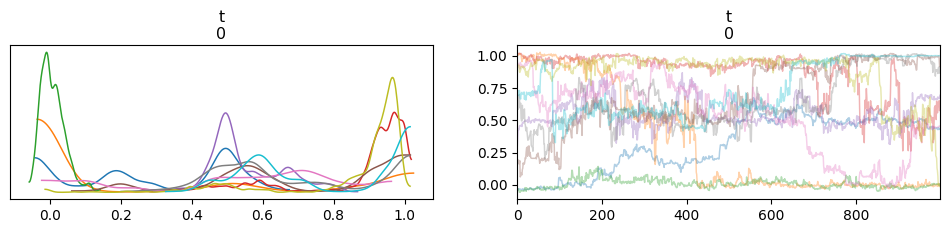

In [20]:
az.plot_trace(idata, compact=False, var_names=['t',])

array([[<Axes: title={'center': 't\n0'}>,
        <Axes: title={'center': 't\n0'}>],
       [<Axes: title={'center': 'tube\n0'}>,
        <Axes: title={'center': 'tube\n0'}>],
       [<Axes: title={'center': 'tube\n1'}>,
        <Axes: title={'center': 'tube\n1'}>],
       [<Axes: title={'center': 'tube\n2'}>,
        <Axes: title={'center': 'tube\n2'}>],
       [<Axes: title={'center': 'tube\n3'}>,
        <Axes: title={'center': 'tube\n3'}>],
       [<Axes: title={'center': 'tube\n4'}>,
        <Axes: title={'center': 'tube\n4'}>],
       [<Axes: title={'center': 'tube\n5'}>,
        <Axes: title={'center': 'tube\n5'}>],
       [<Axes: title={'center': 'tube\n6'}>,
        <Axes: title={'center': 'tube\n6'}>],
       [<Axes: title={'center': 'tube\n7'}>,
        <Axes: title={'center': 'tube\n7'}>],
       [<Axes: title={'center': 'tube\n8'}>,
        <Axes: title={'center': 'tube\n8'}>]], dtype=object)

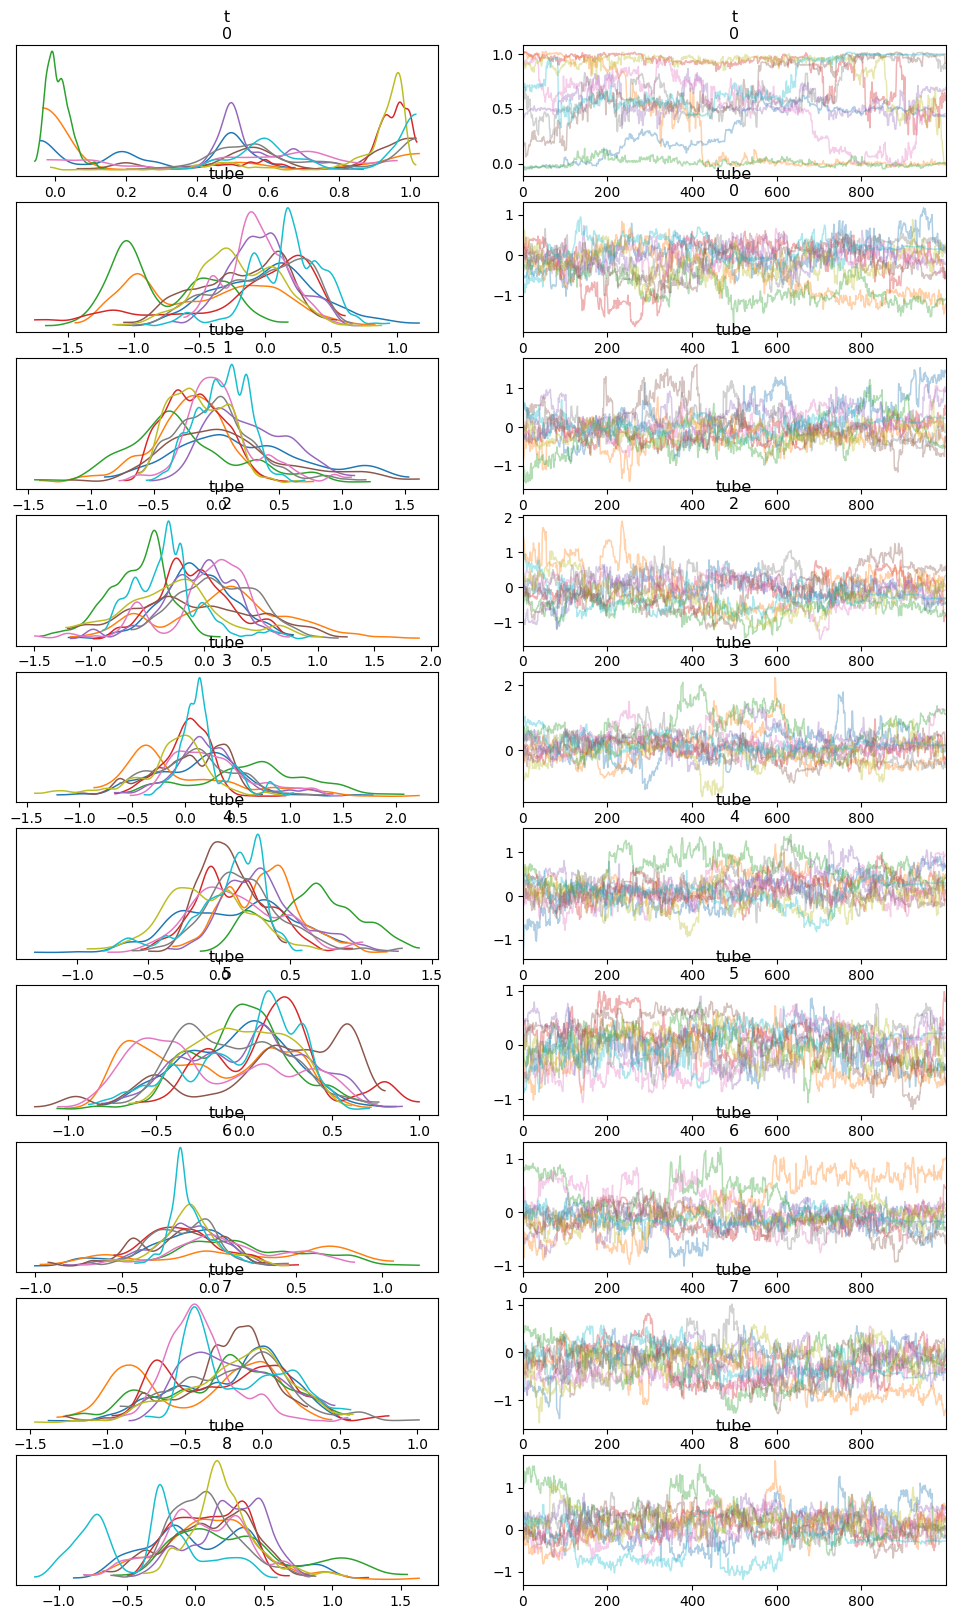

In [21]:
az.plot_trace(idata, compact=False, var_names=['t', 'tube'])

array([[<Axes: ylabel='tube\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tube\n1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tube\n2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tube\n3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tube\n4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tube\n5'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tube\n6'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='t\n0', ylabel='tube\n7'>,
        <Axes: xlabel='tube\n0'>, <Axes: xlabel='tube\n1'>,
        <Axes: xlabel='tube\n2'>, <Axes: xlabel='tube\n3'>,
        <Axes: xlabel='tube\n4'>, <Axes:

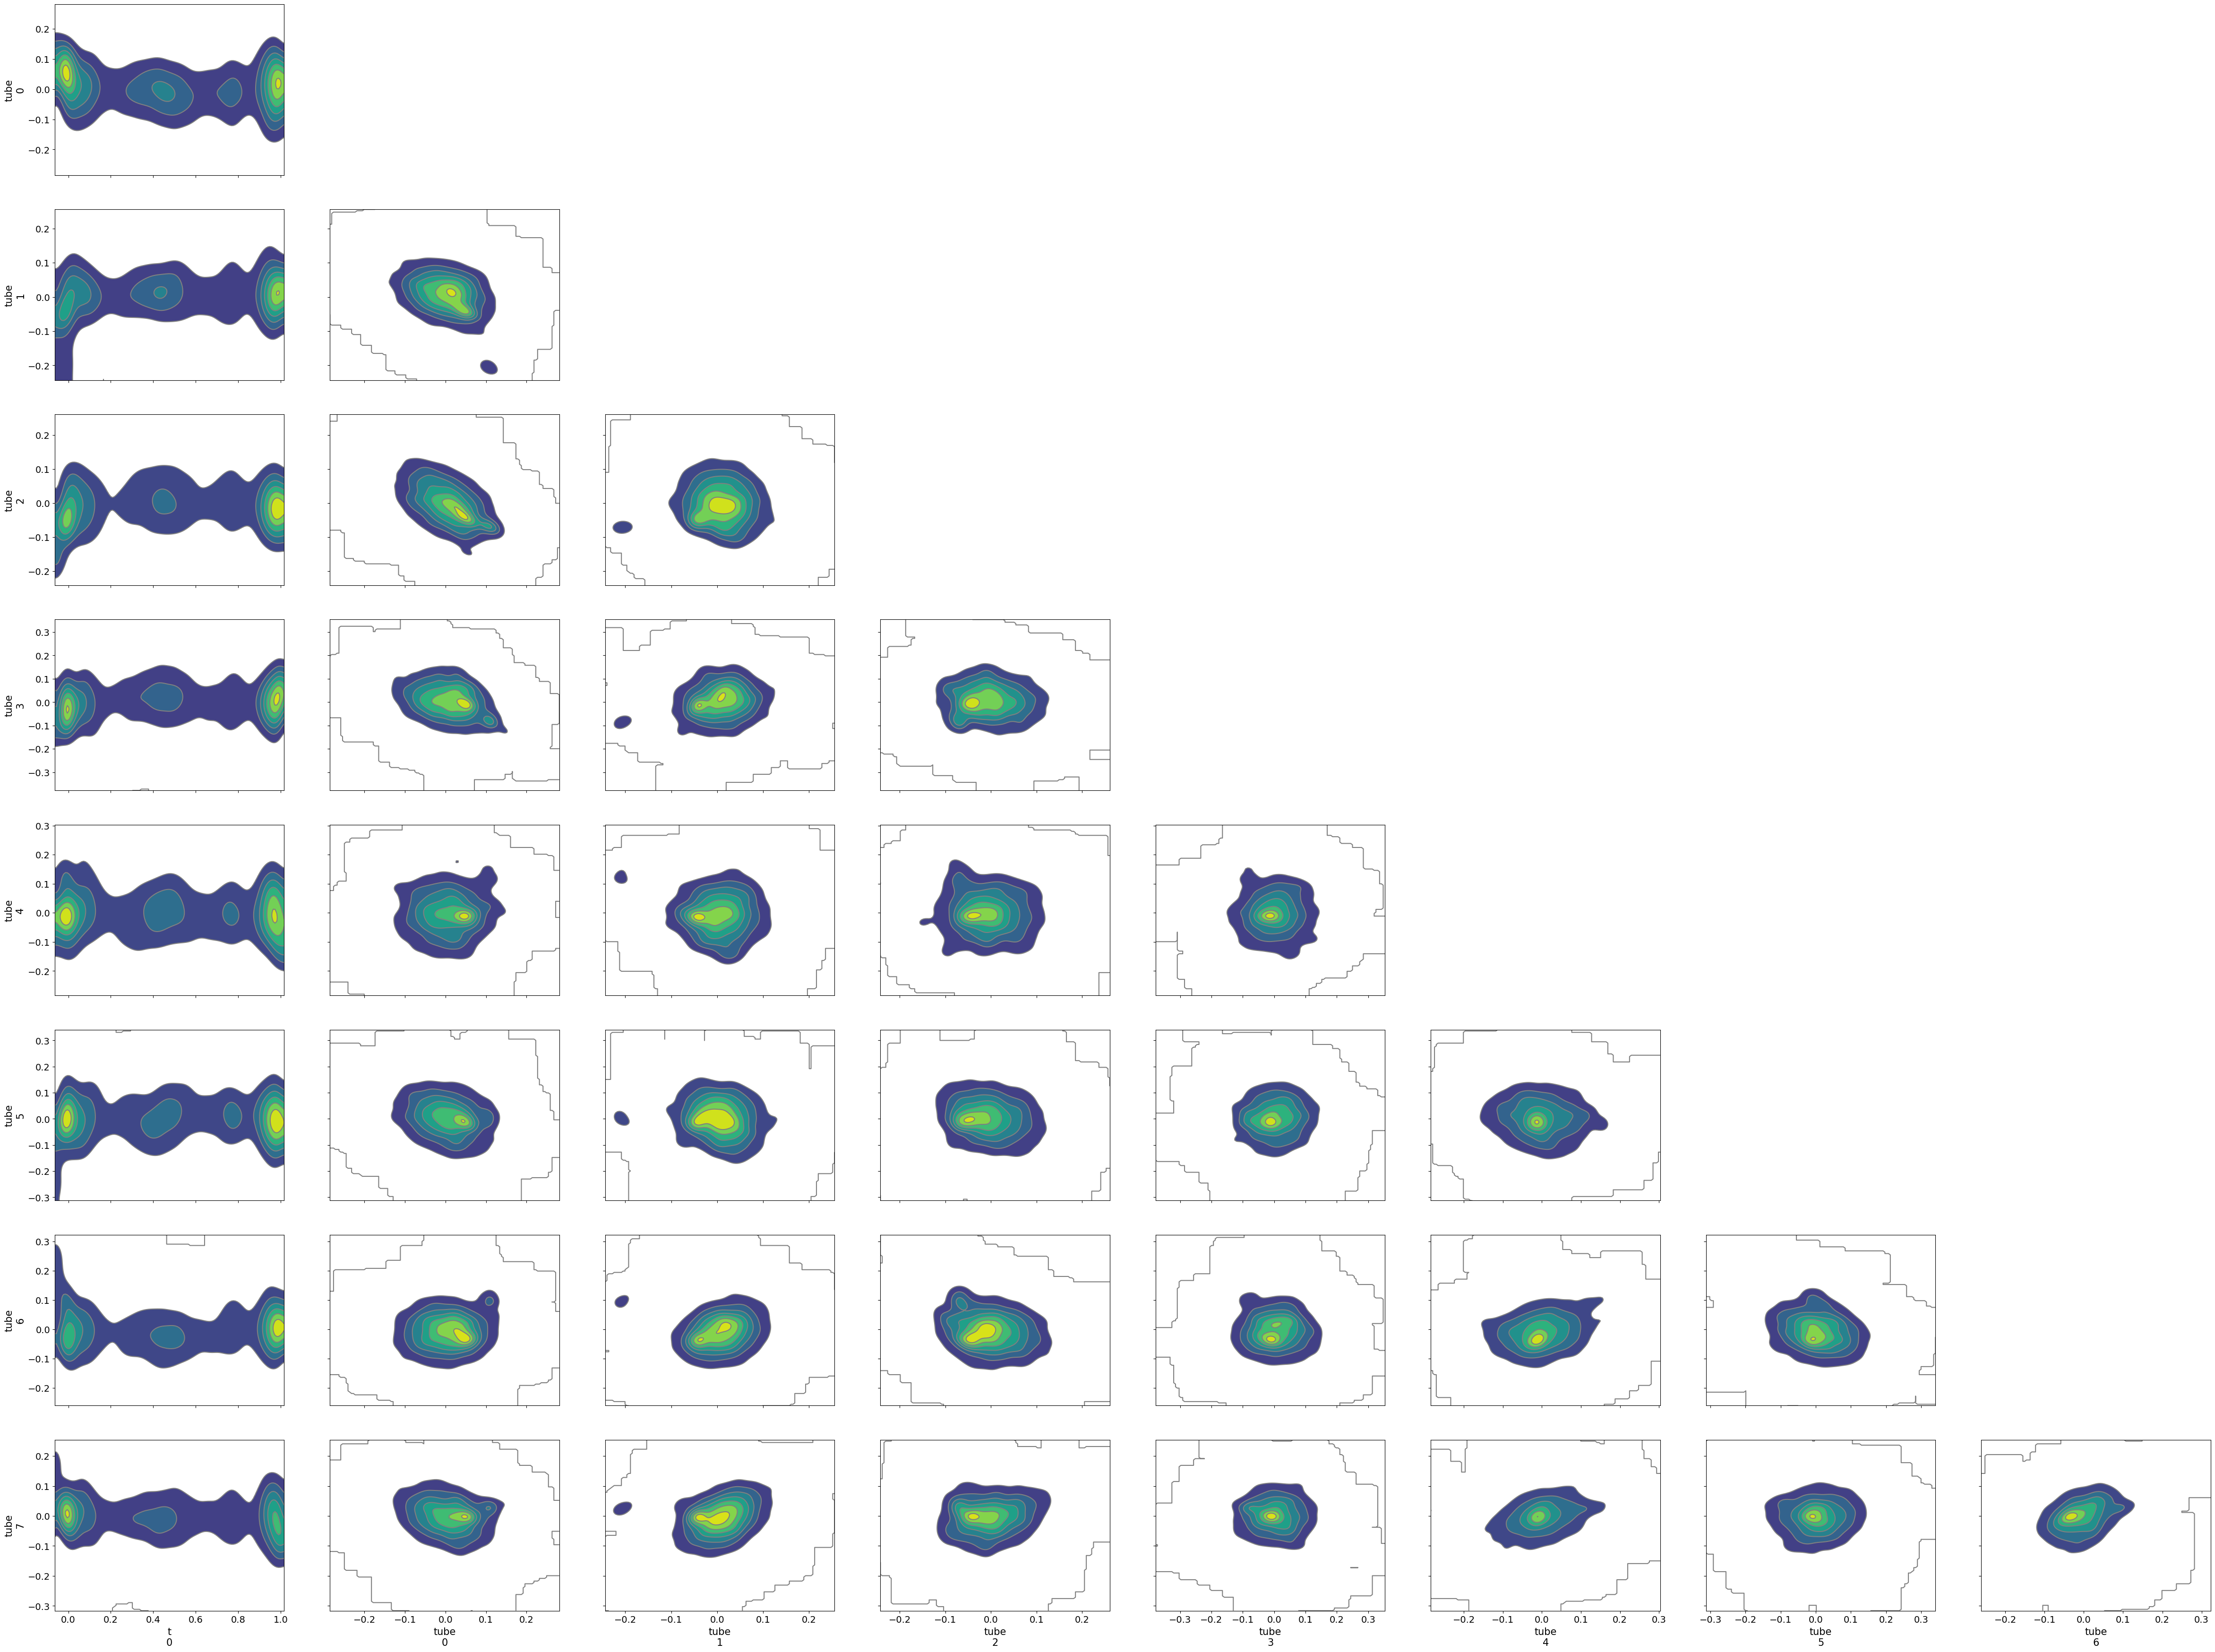

In [58]:
az.plot_pair(idata, var_names=['t', 'tube'], kind="kde",)

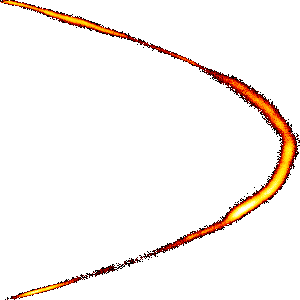

In [64]:
# 2dim t = 1
import datashader as ds
import colorcet

df = idata.posterior['varphi'].to_dataframe().unstack(
    'varphi_dim_0').reset_index()
df.columns = df.columns.map('{0[0]}_{0[1]}'.format)

cvs = ds.Canvas(plot_width=300, plot_height=300)
agg = cvs.points(df, x='varphi_0', y='varphi_1',
                 agg=ds.count())
img = ds.transfer_functions.shade(agg, cmap=colorcet.fire, how='eq_hist')
# img = ds.transfer_functions.dynspread(img, threshold=.1, max_px=10, shape='square')
# img = ds.transfer_functions.spread(img, px=2, shape='square')
img

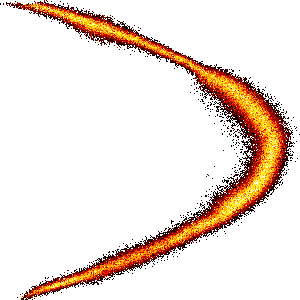

In [ ]:
# 2dim t = 10
import datashader as ds
import colorcet

df = idata.posterior['varphi'].to_dataframe().unstack(
    'varphi_dim_0').reset_index()
df.columns = df.columns.map('{0[0]}_{0[1]}'.format)

cvs = ds.Canvas(plot_width=300, plot_height=300)
agg = cvs.points(df, x='varphi_0', y='varphi_1',
                 agg=ds.count())
img = ds.transfer_functions.shade(agg, cmap=colorcet.fire, how='eq_hist')
# img = ds.transfer_functions.dynspread(img, threshold=.1, max_px=10, shape='square')
# img = ds.transfer_functions.spread(img, px=2, shape='square')
img

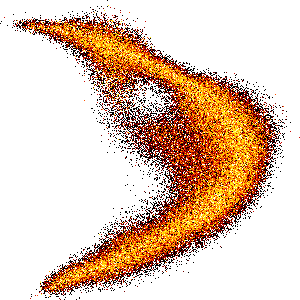

In [69]:
# 2dim t = 100
import datashader as ds
import colorcet

df = idata.posterior['varphi'].to_dataframe().unstack(
    'varphi_dim_0').reset_index()
df.columns = df.columns.map('{0[0]}_{0[1]}'.format)

cvs = ds.Canvas(plot_width=300, plot_height=300)
agg = cvs.points(df, x='varphi_0', y='varphi_1',
                 agg=ds.count())
img = ds.transfer_functions.shade(agg, cmap=colorcet.fire, how='eq_hist')
# img = ds.transfer_functions.dynspread(img, threshold=.1, max_px=10, shape='square')
# img = ds.transfer_functions.spread(img, px=2, shape='square')
img

sample shapes: (10, 10000, 1)
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
t[0]       0.381  0.186   0.088    0.801      0.006    0.005    1018.0   
tube[0]    0.003  0.022  -0.038    0.046      0.000    0.000    5304.0   
tube[1]   -0.019  0.037  -0.092    0.031      0.001    0.001    2653.0   
tube[2]    0.004  0.018  -0.025    0.042      0.000    0.000    4062.0   
tube[3]    0.001  0.014  -0.021    0.031      0.000    0.000    4323.0   
varphi[0]  0.093  0.123  -0.167    0.248      0.004    0.003    1093.0   
varphi[1] -0.010  0.091  -0.210    0.102      0.003    0.003    1275.0   
varphi[2]  0.017  0.060  -0.070    0.122      0.001    0.001    3655.0   
varphi[3]  0.130  0.191  -0.327    0.421      0.007    0.005    1031.0   
varphi[4]  0.097  0.183  -0.275    0.283      0.004    0.003    2397.0   

           ess_tail  r_hat  
t[0]          937.0   1.01  
tube[0]      2011.0   1.00  
tube[1]      2371.0   1.00  
tube[2]      3702.0   1.00  
tube[3]   

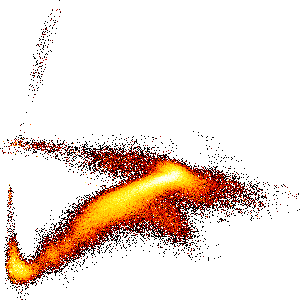

In [84]:
# 5dim t = 1
import colorcet
import datashader as ds
print("sample shapes:", pmap_states.position["t"].shape)
idata = az.from_dict(posterior=jax.vmap(
    jax.vmap(post_proc_fun))(pmap_states.position))
print(az.summary(idata))


df = idata.posterior['varphi'].to_dataframe().unstack(
    'varphi_dim_0').reset_index()
df.columns = df.columns.map('{0[0]}_{0[1]}'.format)

cvs = ds.Canvas(plot_width=300, plot_height=300)
agg = cvs.points(df, x='varphi_0', y='varphi_1',
                 agg=ds.count())
img = ds.transfer_functions.shade(agg, cmap=colorcet.fire, how='eq_hist')
# img = ds.transfer_functions.dynspread(img, threshold=.1, max_px=10, shape='square')
# img = ds.transfer_functions.spread(img, px=2, shape='square')
img

sample shapes: (10, 10000, 1)
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
t[0]       0.693  0.288   0.102    1.006      0.081    0.059      15.0   
tube[0]    0.105  0.222  -0.322    0.492      0.031    0.022      51.0   
tube[1]   -0.142  0.308  -0.799    0.242      0.082    0.063      17.0   
tube[2]    0.021  0.232  -0.464    0.415      0.041    0.029      33.0   
tube[3]   -0.013  0.347  -0.594    0.665      0.079    0.057      20.0   
tube[4]    0.179  0.239  -0.231    0.610      0.046    0.033      27.0   
tube[5]   -0.106  0.319  -0.691    0.445      0.077    0.055      17.0   
tube[6]   -0.034  0.285  -0.560    0.440      0.074    0.053      18.0   
tube[7]    0.033  0.208  -0.403    0.378      0.038    0.027      29.0   
tube[8]   -0.076  0.223  -0.513    0.282      0.054    0.039      19.0   
varphi[0]  0.212  0.282  -0.293    0.583      0.073    0.053      19.0   
varphi[1]  0.037  0.237  -0.304    0.496      0.055    0.040      20.0   
varphi[2

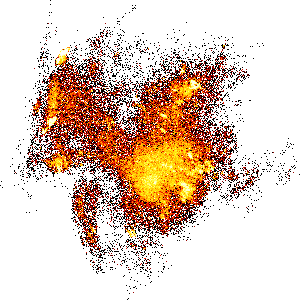

In [96]:
# 10dim t = 1
import colorcet
import datashader as ds
print("sample shapes:", pmap_states.position["t"].shape)
idata = az.from_dict(posterior=jax.vmap(
    jax.vmap(post_proc_fun))(pmap_states.position))
print(az.summary(idata))


df = idata.posterior['varphi'].to_dataframe().unstack(
    'varphi_dim_0').reset_index()
df.columns = df.columns.map('{0[0]}_{0[1]}'.format)

cvs = ds.Canvas(plot_width=300, plot_height=300)
agg = cvs.points(df, x='varphi_0', y='varphi_1',
                 agg=ds.count())
img = ds.transfer_functions.shade(agg, cmap=colorcet.fire, how='eq_hist')
# img = ds.transfer_functions.dynspread(img, threshold=.1, max_px=10, shape='square')
# img = ds.transfer_functions.spread(img, px=2, shape='square')
img

Text(0, 0.5, 'log like')

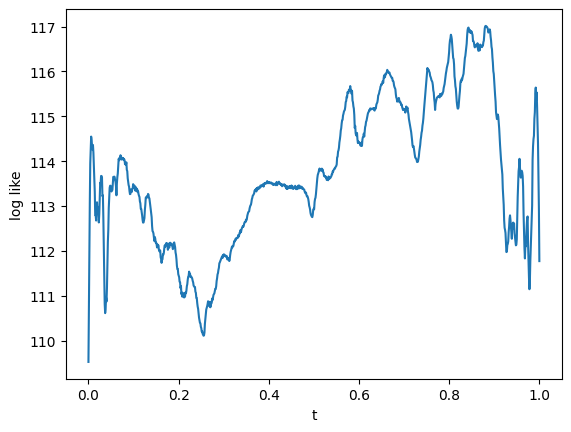

In [97]:
t_space = jnp.linspace(0.0, 1.0, 1000)
nll = s_model.nll(params, t_space, x, y).sum(axis=-1)

plt.plot(t_space, -nll)
plt.xlabel("t")
plt.ylabel("log like")

array([[<Axes: title={'center': 't\n0'}>,
        <Axes: title={'center': 't\n0'}>],
       [<Axes: title={'center': 'tube\n0'}>,
        <Axes: title={'center': 'tube\n0'}>],
       [<Axes: title={'center': 'tube\n1'}>,
        <Axes: title={'center': 'tube\n1'}>],
       [<Axes: title={'center': 'tube\n2'}>,
        <Axes: title={'center': 'tube\n2'}>],
       [<Axes: title={'center': 'tube\n3'}>,
        <Axes: title={'center': 'tube\n3'}>],
       [<Axes: title={'center': 'tube\n4'}>,
        <Axes: title={'center': 'tube\n4'}>],
       [<Axes: title={'center': 'tube\n5'}>,
        <Axes: title={'center': 'tube\n5'}>],
       [<Axes: title={'center': 'tube\n6'}>,
        <Axes: title={'center': 'tube\n6'}>],
       [<Axes: title={'center': 'tube\n7'}>,
        <Axes: title={'center': 'tube\n7'}>],
       [<Axes: title={'center': 'tube\n8'}>,
        <Axes: title={'center': 'tube\n8'}>]], dtype=object)

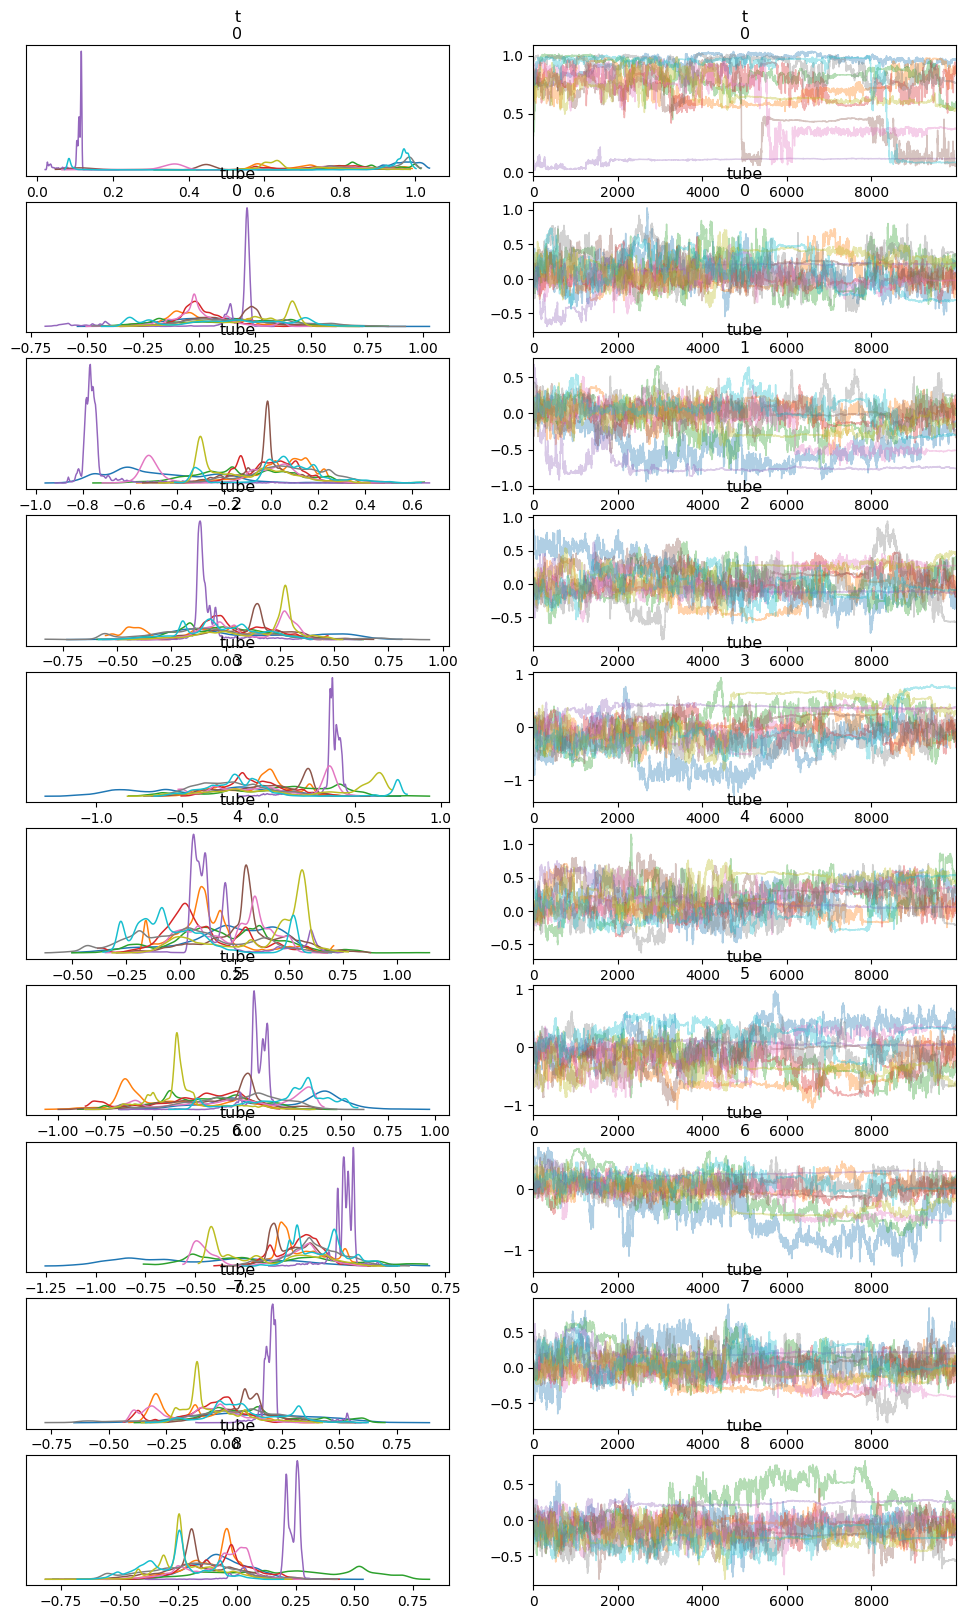

In [99]:
az.plot_trace(idata, compact=False, var_names=['t', 'tube'])

sample shapes: (10, 10000, 1)
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
t[0]       0.569  0.334   0.045    1.026      0.025    0.021     192.0   
tube[0]    0.020  0.515  -0.931    0.928      0.066    0.047      65.0   
tube[1]   -0.248  0.470  -1.199    0.559      0.045    0.032     112.0   
tube[2]   -0.151  0.494  -1.118    0.731      0.023    0.016     475.0   
tube[3]   -0.038  0.512  -1.038    0.832      0.025    0.018     401.0   
tube[4]    0.043  0.437  -0.832    0.861      0.013    0.009    1279.0   
tube[5]   -0.092  0.486  -1.140    0.724      0.028    0.027     329.0   
tube[6]    0.082  0.527  -0.888    1.098      0.072    0.062      78.0   
tube[7]    0.027  0.423  -0.755    0.877      0.009    0.006    2044.0   
tube[8]   -0.170  0.449  -0.988    0.704      0.013    0.009     993.0   
varphi[0]  0.321  0.429  -0.469    1.107      0.030    0.030     321.0   
varphi[1]  0.134  0.385  -0.701    0.751      0.034    0.024     144.0   
varphi[2

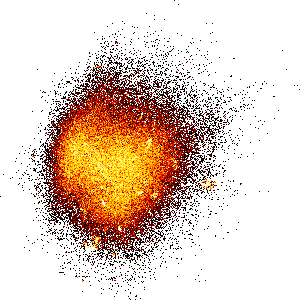

In [102]:
# 10dim t = 100
import colorcet
import datashader as ds
print("sample shapes:", pmap_states.position["t"].shape)
idata = az.from_dict(posterior=jax.vmap(
    jax.vmap(post_proc_fun))(pmap_states.position))
print(az.summary(idata))


df = idata.posterior['varphi'].to_dataframe().unstack(
    'varphi_dim_0').reset_index()
df.columns = df.columns.map('{0[0]}_{0[1]}'.format)

cvs = ds.Canvas(plot_width=300, plot_height=300)
agg = cvs.points(df, x='varphi_0', y='varphi_1',
                 agg=ds.count())
img = ds.transfer_functions.shade(agg, cmap=colorcet.fire, how='eq_hist')
# img = ds.transfer_functions.dynspread(img, threshold=.1, max_px=10, shape='square')
# img = ds.transfer_functions.spread(img, px=2, shape='square')
img

array([[<Axes: title={'center': 't\n0'}>,
        <Axes: title={'center': 't\n0'}>],
       [<Axes: title={'center': 'tube\n0'}>,
        <Axes: title={'center': 'tube\n0'}>],
       [<Axes: title={'center': 'tube\n1'}>,
        <Axes: title={'center': 'tube\n1'}>],
       [<Axes: title={'center': 'tube\n2'}>,
        <Axes: title={'center': 'tube\n2'}>],
       [<Axes: title={'center': 'tube\n3'}>,
        <Axes: title={'center': 'tube\n3'}>],
       [<Axes: title={'center': 'tube\n4'}>,
        <Axes: title={'center': 'tube\n4'}>],
       [<Axes: title={'center': 'tube\n5'}>,
        <Axes: title={'center': 'tube\n5'}>],
       [<Axes: title={'center': 'tube\n6'}>,
        <Axes: title={'center': 'tube\n6'}>],
       [<Axes: title={'center': 'tube\n7'}>,
        <Axes: title={'center': 'tube\n7'}>],
       [<Axes: title={'center': 'tube\n8'}>,
        <Axes: title={'center': 'tube\n8'}>]], dtype=object)

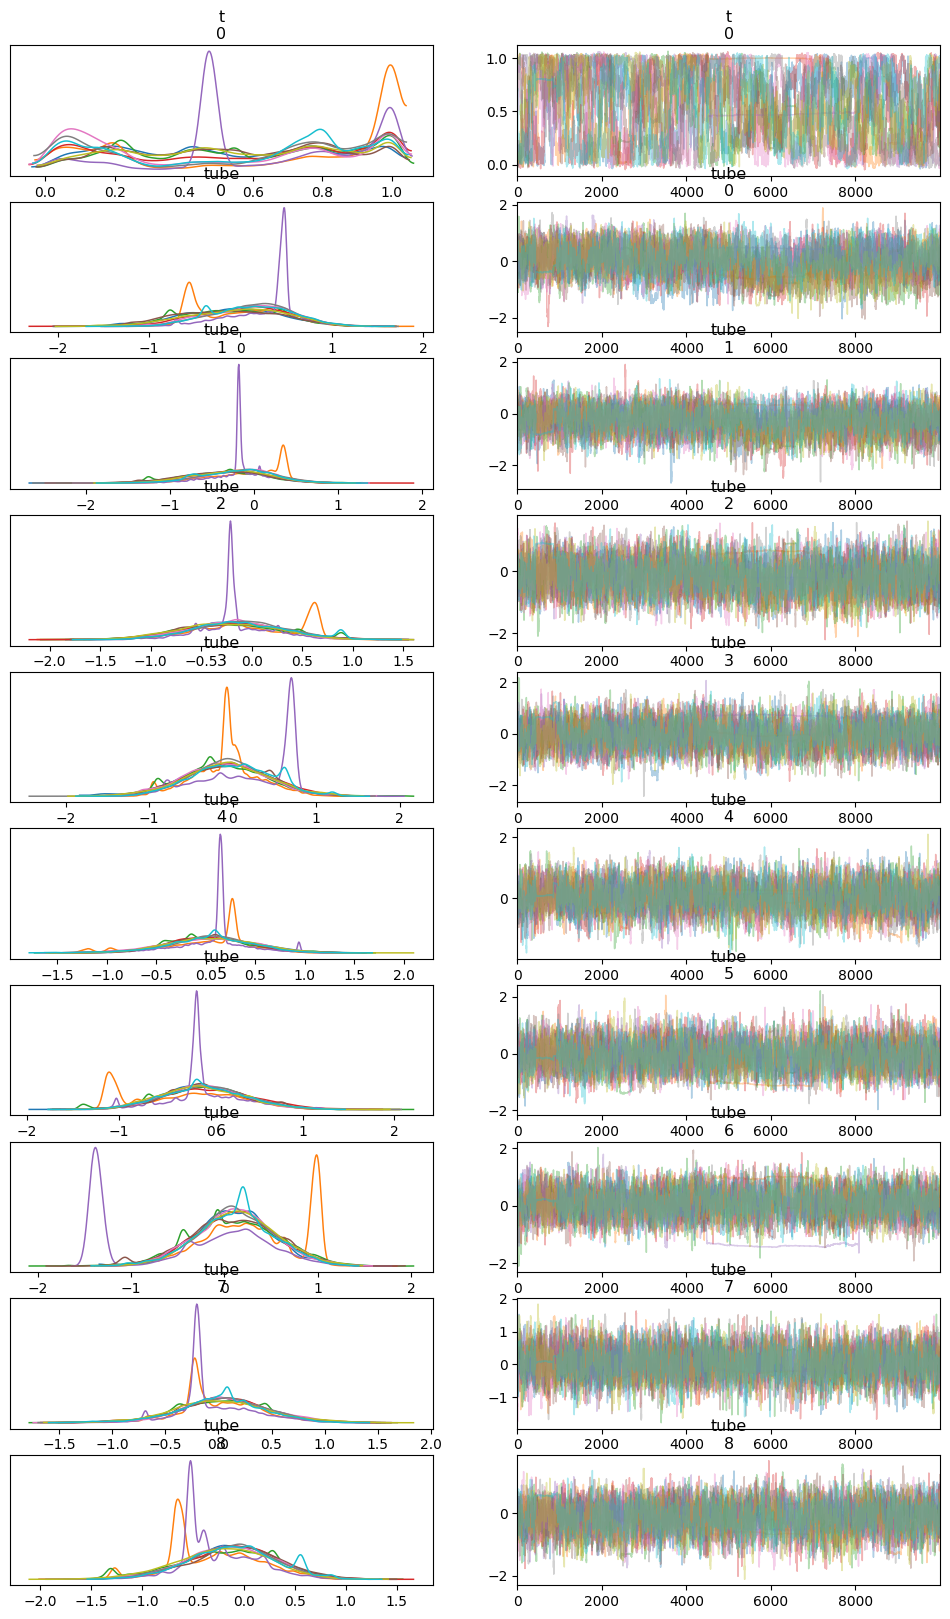

In [103]:
az.plot_trace(idata, compact=False, var_names=['t', 'tube'])